In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import quandl
import quandl as q
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
quandl.ApiConfig.api_key = "-qMZRw2S5XascrrTLjF4"

In [2]:
#pega os dados da API
msft_data = q.get("EOD/MSFT", start_date="2010-01-01", end_date="2020-01-01")
msft_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,31.7500,32.07,31.29,31.880,154507000.0,0.0,1.0,27.484005,27.761009,27.085812,27.596538,154507000.0
2013-09-04,31.3900,31.47,31.11,31.195,142320600.0,0.0,1.0,27.172375,27.241626,26.929997,27.003576,142320600.0
2013-09-05,31.1000,31.44,30.95,31.235,71644900.0,0.0,1.0,26.921340,27.215657,26.791495,27.038201,71644900.0
2013-09-06,31.3100,31.39,31.13,31.152,75434900.0,0.0,1.0,27.103124,27.172375,26.947309,26.966354,75434900.0
2013-09-09,31.2208,31.79,31.20,31.655,49628500.0,0.0,1.0,27.025909,27.518631,27.007904,27.401769,49628500.0


In [3]:
# chama `Adj Close` para `daily_close`
daily_close = msft_data[['Adj_Close']]

In [4]:
def getlinear_coefi(x,y):

    m = (len(x) * np.sum(x*y) - np.sum(x) * np.sum(y)) / (len(x)*np.sum(x*x) - np.sum(x) * np.sum(x))
    return m

def train_model_and_forecast(train, test):
    step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                       seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True,
                       stepwise = False)

    step_model.fit(train)

    future_forecast = step_model.predict(n_periods = len(test))

    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])

    y = []
    x = []

    forecast_n = future_forecast.values[0]
    daily_n_1 = train.values[len(train)-1]

    for el in future_forecast.values:
        x.append(float(el))
    for i in range(len(future_forecast.values)):
        y.append(i)

    return [x,y,forecast_n,daily_n_1]

In [5]:
compra_oportunidade = []
venda_defesa = []
venda_ganho_fixado = []
operacoes = []
status_op = {}
num_op = 0

percentual_ganho = 5
dif_compra = percentual_ganho/100

dias_anteriores_mid = 15
dias_forecast_mid = 15
dias_forecast = 5
dias_treino_antes = 5


m_n_1 = 1
index_ultima_compra_oportunidade_n_1 = -1
forecast_n = 1
forecast_n_1 = 1
daily_n_1 = 1


for k in range(30,len(daily_close[:150])):
    train = daily_close[k-dias_treino_antes:k-1]
    test = daily_close[k:k+dias_forecast]
    
    resultado_modelo = train_model_and_forecast(train, test)
    m = getlinear_coefi(np.array(resultado_modelo[0]),np.array(resultado_modelo[1]))
    m_n = m
    forecast_n = resultado_modelo[2]
    daily_n_1 = resultado_modelo[3]
    
    #OPORTUNIDADE DE COMPRA, pq acha que vai crescer abrupto
    if m_n > 25:
        
        resultado_modelo_mid = train_model_and_forecast(daily_close[k-dias_anteriores_mid:k-1], daily_close[k:k+dias_forecast_mid])
        m_mid = getlinear_coefi(np.array(resultado_modelo_mid[0]),np.array(resultado_modelo_mid[1]))
        if m_mid > 5:
            print('compra:')
            compra_oportunidade.append(k)
            
            num_op = num_op + 1
            status_op['venda'] = 0.1
            status_op['compra'] = k
            status_op['index'] = num_op
  
            
    #VENDA DE DEFESA, vê que o bicho vai cair bruscamente e ja tava caindo nas ultimas semanas
    if m_n < -25:
        resultado_modelo_mid = train_model_and_forecast(daily_close[k-dias_anteriores_mid:k-1], daily_close[k:k+dias_forecast_mid])
        m_mid = getlinear_coefi(np.array(resultado_modelo_mid[0]),np.array(resultado_modelo_mid[1]))
        if m_mid < -3:
            venda_defesa.append(k)
            if status_op['venda'] == 0.1:
                status_op['venda'] = k
                status_op['tipo_venda'] = 'protecao'


    
    #VENDA PQ deu um ganho okzinho previamente setado
    #index_ultima_compra_oportunidade = len(compra_oportunidade)-1
    #if index_ultima_compra_oportunidade == index_ultima_compra_oportunidade_n_1+1:
    #    if msft_data['Adj_Close'][compra_oportunidade[index_ultima_compra_oportunidade]]*(1+dif_compra) < forecast_n:
    #        venda_ganho_fixado.append(k)
    #        index_ultima_compra_oportunidade_n_1 = index_ultima_compra_oportunidade
    try:
        
        if msft_data['Adj_Close'][int(status_op['compra'])]*(1+dif_compra) < forecast_n:
            if status_op['venda'] == 0.1:
                status_op['venda'] = k
                status_op['tipo_venda'] = 'ganho'
                venda_ganho_fixado.append(k)
    except:
        continue

    if isinstance(status_op['venda'], int):   
        operacoes.append(status_op)
        status_op = {}
        status_op['venda'] = 0.1
       
    
    print(k,forecast_n_1,daily_n_1,forecast_n,m_n_1,m_n)
    forecast_n_1 = forecast_n    
    m_n_1 = m_n

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3.501, BIC=1.698, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3.724, BIC=1.020, Time=0.104 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.408, BIC=0.803, Time=0.201 seconds
Total fit time: 0.320 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=0.797, BIC=-1.005, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1.918, BIC=-0.786, Time=0.094 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.891, BIC=0.285, Time=0.176 seconds
Total fit time: 0.317 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=0.071, BIC=-1.732, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1.206, BIC=-1.498, Time=0.122 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit 

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=5.005, BIC=2.300, Time=0.109 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.312, BIC=2.706, Time=0.141 seconds
Total fit time: 0.382 seconds
47 [31.22644645] [31.71697462] [32.07332891] 8.66413027265054 2.80619603975925
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.213, BIC=5.411, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.940, BIC=6.236, Time=0.145 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.026 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.422, BIC=6.817, Time=0.141 seconds
Total fit time: 0.342 seconds
48 [32.07332891] [33.05005707] [33.81614636] 2.80619603975925 1.3053308780891872
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.116, BIC=9.313, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.566, BIC=8.862, Time=0.078 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.493, BIC=4.887, Time=0.156 seconds
Total fit time: 0.283 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-1.079, BIC=-2.882, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-1.192, BIC=-3.896, Time=0.156 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-3.886, BIC=-6.590, Time=0.133 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-2.972, BIC=-6.577, Time=0.276 seconds
Total fit time: 0.596 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.051, BIC=2.249, Time=0.000 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.305, BIC=2.600, Time=0.125 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.038 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.302, BIC=3.697, Time=0.152 seconds
Total fit time: 0.330 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.788, BIC=2.985, Time=0.000 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; A

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2.432, BIC=-1.174, Time=0.156 seconds
Total fit time: 0.299 seconds
80 [32.17965976] [31.94124884] [32.32522697] 12.283713290740682 5.4982534261093345
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.950, BIC=3.147, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4.750, BIC=2.046, Time=0.079 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-0.847, BIC=-3.552, Time=0.080 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=0.056, BIC=-3.549, Time=0.141 seconds
Total fit time: 0.315 seconds
81 [32.32522697] [32.34247698] [32.22819453] 5.4982534261093345 5.102370244334405
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.079, BIC=2.277, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4.885, BIC=2.180, Time=0.131 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.675, BIC=3.069, Time=0.162 seconds
Tot

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.560, BIC=6.955, Time=0.216 seconds
Total fit time: 0.363 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.028, BIC=7.225, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.314, BIC=6.610, Time=0.127 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.040 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.205, BIC=6.600, Time=0.128 seconds
Total fit time: 0.313 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.481, BIC=8.679, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.297, BIC=7.593, Time=0.118 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.578, BIC=2.973, Time=0.138 seconds
Total fit time: 0.303 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.207, BIC=9.405, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.2

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.686, BIC=6.080, Time=0.128 seconds
Total fit time: 0.253 seconds
109 [31.5574654] [31.24346077] [30.65615581] -6.7439994324795585 -1.7026929314153532
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.629, BIC=3.826, Time=0.000 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.954, BIC=3.250, Time=0.109 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.016 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.955, BIC=3.349, Time=0.157 seconds
Total fit time: 0.298 seconds
110 [30.65615581] [31.5574654] [31.47024079] -1.7026929314153532 -11.464653876302387
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.550, BIC=4.747, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.563, BIC=4.859, Time=0.078 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.494, BIC=5.889, Time=0.179 seconds
Tota

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.441, BIC=4.737, Time=0.092 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=6760.114, BIC=6757.410, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.716, BIC=1.110, Time=0.078 seconds
Total fit time: 0.233 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.999, BIC=4.196, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.471, BIC=3.767, Time=0.083 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.811, BIC=4.206, Time=0.140 seconds
Total fit time: 0.271 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=0.351, BIC=-1.452, Time=0.000 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=0.163, BIC=-2.542, Time=0.094 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-3.799, BIC=-7.404, Time=0.236 

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2.157, BIC=-1.449, Time=0.258 seconds
Total fit time: 0.546 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.634, BIC=5.831, Time=0.000 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.020, BIC=5.316, Time=0.143 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.176, BIC=5.571, Time=0.125 seconds
Total fit time: 0.287 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3.128, BIC=1.325, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.903, BIC=0.199, Time=0.125 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-8.903, BIC=-11.607, Time=0.109 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-9.120, BIC=-12.725, Time=0.330 seconds
Total fit time: 0.596 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.679, BIC=3.876, Time=0.000 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=

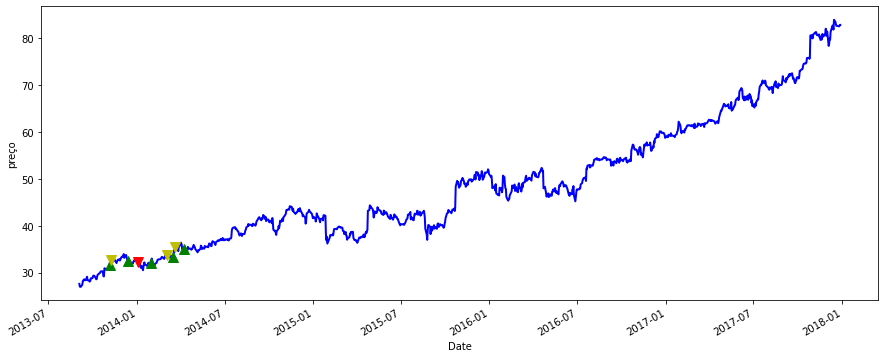

In [6]:
fig = plt.figure()

plt1 = fig.add_subplot(111,  ylabel='preço')

msft_data['Adj_Close'].plot(ax=plt1, color='b', lw=2.)


# venda_protecao
plt1.plot(msft_data['Adj_Close'][venda_defesa], 'v', markersize=10, color='r')

# compra_oportunidade
plt1.plot(msft_data['Adj_Close'][compra_oportunidade], '^', markersize=10, color='g')

# venda_por_ganho_ok
plt1.plot(msft_data['Adj_Close'][venda_ganho_fixado], 'v', markersize=10, color='y')

# show
plt.show()

In [7]:
operacoes

[{'venda': 48, 'compra': 45, 'index': 1, 'tipo_venda': 'ganho'},
 {'venda': 85, 'compra': 71, 'index': 2, 'tipo_venda': 'protecao'},
 {'venda': 125, 'compra': 102, 'index': 3, 'tipo_venda': 'ganho'},
 {'venda': 137, 'compra': 134, 'index': 4, 'tipo_venda': 'ganho'}]

In [8]:
prod = 1
for el in operacoes:
    print(msft_data['Adj_Close'][el['venda']]/msft_data['Adj_Close'][el['compra']])
    prod = prod*msft_data['Adj_Close'][el['venda']]/msft_data['Adj_Close'][el['compra']]

1.0311135371179039
0.9916711445459431
1.0555757720489292
1.0599211563731932


In [9]:
prod

1.1440292790749669

In [59]:
preco_venda = []
preco_compra = []
venda_total = 0
compra_total = 0
for el in venda:
    preco_venda.append(msft_data['Adj_Close'][el])
    venda_total = venda_total + msft_data['Adj_Close'][el]
for el in compra:
    preco_compra.append(msft_data['Adj_Close'][el])
    compra_total = compra_total + msft_data['Adj_Close'][el]